In [1]:
# execute locally to include figures
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

plt.rcParams.update({'font.size': 8})

def label_subplots_ABC(fig, axs, x_shift, y_shift, start_idx=0, **text_kws):
    labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'][start_idx:]
    if type(x_shift) != list():
        x_shift = [x_shift] * len(axs)
    if type(y_shift) != list():
        y_shift = [y_shift] * len(axs)
    for i, ax in enumerate(axs):
        # Get the position of the subplot
        pos = ax.get_position()  # returns (left, bottom, width, height)

        # Annotate at the upper-left corner of each subplot
        fig.text(pos.x0 + x_shift[i], pos.y1 + y_shift[i], labels[i], **text_kws)   

In [2]:
ls network_data/numpy_arrays/

dual_stim_mean.npy        morph_1_fr_sem.npy        no_morph_current_mean.npy
dual_stim_sem.npy         morph_2_current_mean.npy  no_morph_current_sem.npy
morph_1_current_mean.npy  morph_2_current_sem.npy   no_morph_fr_mean.npy
morph_1_current_sem.npy   morph_2_fr_mean.npy       no_morph_fr_sem.npy
morph_1_fr_mean.npy       morph_2_fr_sem.npy        time_average_sem/


In [3]:
labels=['morph_1', 'morph_2', 'no_morph']
fr_mean = [np.load(''.join(['network_data/numpy_arrays/', l, '_fr_mean.npy'])) for l in labels]
fr_sem = [np.load(''.join(['network_data/numpy_arrays/', l, '_fr_sem.npy'])) for l in labels]
fr_tsem = [np.load(''.join(['network_data/numpy_arrays/time_average_sem/', l, '_fr_sem.npy'])) for l in labels]
cu_mean = [np.load(''.join(['network_data/numpy_arrays/', l, '_current_mean.npy'])) for l in labels]
cu_sem = [np.load(''.join(['network_data/numpy_arrays/', l, '_current_sem.npy'])) for l in labels]
# dimensions encode 3 stimulator radii [50, 150, 250], time, and space

In [4]:
np.shape(fr_sem)

(3, 3, 30, 80)

In [5]:
np.shape(fr_tsem)

(3, 3, 80)

In [6]:
dx_fr = 40 # um
dt_fr = 5 #ms
x_fr = np.arange(0,fr_mean[0].shape[2]*dx_fr, dx_fr)
t_fr = np.arange(0,fr_mean[0].shape[1]*dt_fr, dt_fr)
dx_cu = 2 #um
dt_cu = 1 #ms
x_cu = np.arange(0,cu_mean[0].shape[2]*dx_cu, dx_cu)
t_cu = np.arange(0,cu_mean[0].shape[1]*dt_cu, dt_cu)

# calc r50
def find_half_max_x(x, y):

    y_max = max(y)
    half_max = y_max / 2
    
    # Find the index where the y-value is closest to the half-max
    closest_index = np.argmin(np.abs(np.array(y) - half_max))
    
    # Get the value at the closest index
    closest_y = y[closest_index]
    
    # If the closest value is equal to half-max, return it
    if closest_y == half_max:
        return x[closest_index]

    # Interpolate if the closest value is not exactly half-max
    if closest_y > half_max:  # Interpolate between the closest index and the next one
        if closest_index + 1 < len(y):
            x0, y0 = x[closest_index], y[closest_index]
            x1, y1 = x[closest_index + 1], y[closest_index + 1]
            # Linear interpolation
            x_half_max = x0 + (half_max - y0) * (x1 - x0) / (y1 - y0)
            return x_half_max
    else:  # Interpolate between the closest index and the previous one
        if closest_index - 1 >= 0:
            x0, y0 = x[closest_index], y[closest_index]
            x1, y1 = x[closest_index - 1], y[closest_index - 1]
            # Linear interpolation
            x_half_max = x0 + (half_max - y0) * (x1 - x0) / (y1 - y0)
            return x_half_max
    
r50 = {'output':dict(), 'input':dict()}
for il, label in enumerate(labels):
    r50['input'][label]  = dict()
    r50['output'][label] = dict()
    for ir, radius in enumerate([50,150]):
        r50['input'][label][radius]  = find_half_max_x(x_cu, cu_mean[il][ir].mean(axis=0))
        r50['output'][label][radius] = find_half_max_x(x_fr, fr_mean[il][ir].mean(axis=0))

In [7]:
def plot_response(main, inset1, inset2, resp_t_x, sem_t_x, dx, dt, plot_time_resp_at_um=200, 
                  main_kws={}, inset1_kws={}, inset2_kws={}, 
                  sbar_inset_draw=False, inset_title=False, fr_tsem=None, plot_sem=True):
    x = np.arange(0,resp_t_x.shape[1]*dx, dx)
    t = np.arange(0,resp_t_x.shape[0]*dt, dt)
    stim_on_time_idx = int(0 / dt)
    stim_off_time_idx = int(100 / dt) # ms
    resp_tmean = resp_t_x[stim_on_time_idx:stim_off_time_idx].mean(axis=0)
    main.plot(x, resp_tmean, **main_kws)
    main_kws_wo_label = {k: v for k, v in main_kws.items() if k != 'label'}
    if plot_sem:
        main.fill_between(x, resp_tmean-fr_tsem, resp_tmean+fr_tsem, alpha=0.2, **main_kws_wo_label)
    resp_center = resp_t_x[:,0]
    sem_center = sem_t_x[:,0]
    resp_middle = resp_t_x[:,int(plot_time_resp_at_um/dx)]
    sem_middle = sem_t_x[:,int(plot_time_resp_at_um/dx)]
    inset1.plot(t, resp_center/resp_center.max(), **inset1_kws)
    inset2.plot(t, resp_middle/resp_middle.max(), **inset2_kws)
    if plot_sem:
        inset1_kws_wo_label = {k: v for k, v in inset1_kws.items() if k != 'label'}
        inset1.fill_between(t, (resp_center-sem_center)/resp_center.max(), (resp_center+sem_center)/resp_center.max(), alpha=0.2, **inset1_kws_wo_label)
        inset2_kws_wo_label = {k: v for k, v in inset2_kws.items() if k != 'label'}
        inset2.fill_between(t, (resp_middle-sem_middle)/resp_middle.max(), (resp_middle+sem_middle)/resp_middle.max(), alpha=0.2, **inset2_kws_wo_label)
    
    main.set_xlim(0,500)
    main.spines['top'].set_visible(False)
    main.spines['right'].set_visible(False)
    for ax in [inset1, inset2]:
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
    if sbar_inset_draw:    
        # Add two scalebars forming a corner using rectangle patches
        for ax, sb_ly in zip([inset1, inset2], [int((np.max(resp_center)*0.4)/2)*2,int((np.max(resp_middle)*0.4)/2)*2]):
            scale_length_x = 20 #ms
            #scale_length_y = sb_ly #Hz
            x_start, y_start = ax.get_xlim()[0], ax.get_ylim()[0]
            y_length = ax.get_ylim()[1] - ax.get_ylim()[0]
            rect_x = patches.Rectangle((x_start, y_start), scale_length_x, 0, linewidth=2, edgecolor='black', facecolor='black')
            #rect_y = patches.Rectangle((x_start, y_start), 0, scale_length_y, linewidth=2, edgecolor='black', facecolor='black')    
            ax.add_patch(rect_x)
            #ax.add_patch(rect_y)
            # Add labels for scalebars
            ax.text(x_start + scale_length_x / 2, y_start - 0.05*y_length, '  '+str(scale_length_x)+' ms', 
                           ha='center', va='top', fontsize=8, color='black')
            #ax.text(x_start - 0.5, y_start + scale_length_y / 2, '  '+str(scale_length_y)+' Hz', 
            #               ha='right', va='center', fontsize=8, color='black', rotation=90)
    if inset_title:
        inset1.set_title('Response @0µm', loc='left', fontsize=8, y=0.95)
        inset2.set_title('@200µm', loc='left', fontsize=8, y=0.95)

    return main, inset1, inset2

def get_insets(fig, main):
    # Get position of the main plot
    pos = main.get_position()
    inset_width = pos.width * 0.4
    inset_height = pos.height * 0.2
    inset_bottom = pos.y0 + pos.height + 0.01
    # Inset subplots above main plot
    inset1 = fig.add_axes([pos.x0+pos.width*0.1, inset_bottom, inset_width, inset_height])
    inset2 = fig.add_axes([pos.x0+pos.width*0.15+inset_width, inset_bottom, inset_width, inset_height])
    return inset1, inset2

/tmp/ipykernel_11427/838264056.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


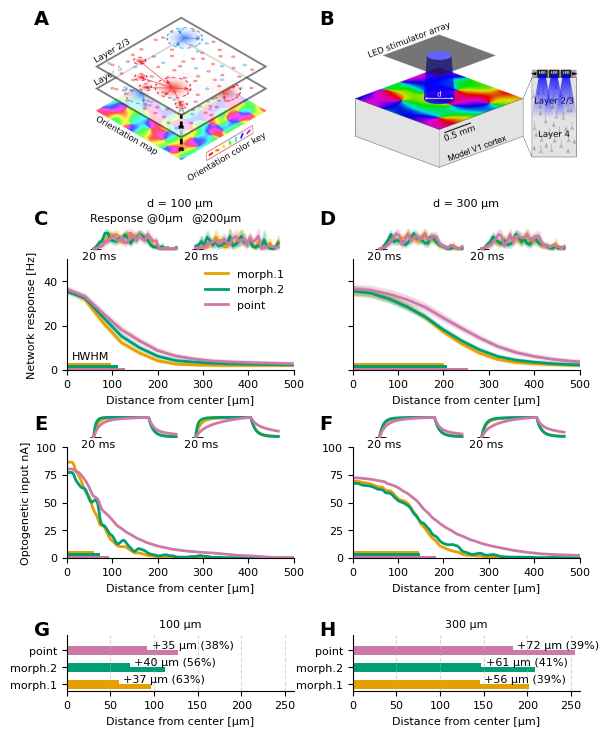

In [11]:
a4_w, a4_h = 8.27, 11.69
fig, axs = plt.subplots(4, 2, figsize=(a4_w*0.8, a4_h*0.75), gridspec_kw={'hspace': 0.7, 'wspace': 0.26, 'height_ratios':[1.5,1,1,0.5]})

# import sketches on upper panels:
axs[0, 0].axis('off')  # Upper left
axs[0, 1].axis('off')  # Upper right
axs[0, 0].imshow(mpimg.imread('/home/david/Documents/papers/reduction_paper/model_V1.png'))
axs[0, 1].imshow(mpimg.imread('/home/david/Documents/papers/reduction_paper/stimulator_model.png'))

colors = []
for ir, stim_radius in enumerate([50,150]):
    main1 = axs[1, ir]
    inset11, inset12 = get_insets(fig, main=main1)
    main2 = axs[2, ir]
    inset21, inset22 = get_insets(fig, main=main2)
    for il, (label, sb_draw, inset_title, c) in enumerate(zip(['morph.1', 'morph.2',   'point'],
                                                              [    False,     False,      True],
                                                              [     True,     False,     False],
                                                              ['#E69F00', '#009E73', '#CC79A7']
                                                              )):
        colors.append(c)
        main, inset1, inset2 = plot_response(
            main=main1,
            inset1=inset11,
            inset2=inset12,
            resp_t_x=fr_mean[il][ir],
            sem_t_x=fr_sem[il][ir],
            dx=dx_fr, 
            dt=dt_fr, 
            plot_time_resp_at_um=200, 
            main_kws=dict(label=label, color=c, lw=2), 
            inset1_kws=dict(color=c, lw=2), 
            inset2_kws=dict(color=c, lw=2),
            sbar_inset_draw=sb_draw,
            inset_title=inset_title*(ir==0),
            fr_tsem=fr_tsem[il][ir],
            plot_sem=True
        )
        main, inset1, inset2 = plot_response(
            main=main2,
            inset1=inset21,
            inset2=inset22,
            resp_t_x=cu_mean[il][ir], 
            sem_t_x=cu_sem[il][ir],
            dx=dx_cu, 
            dt=dt_cu, 
            plot_time_resp_at_um=200, 
            main_kws=dict(label=label, color=c, lw=2), 
            inset1_kws=dict(color=c, lw=2), 
            inset2_kws=dict(color=c, lw=2),
            sbar_inset_draw=sb_draw,
            plot_sem=False
        )

axs[1,0].set_ylabel('Network response [Hz]')
axs[1,1].set_yticklabels([])
axs[2,0].set_ylabel('Optogenetic input nA]')
axs[2,1].set_yticklabels([])
for ax in axs[1:,:].flatten():
    ax.set_xlabel('Distance from center [µm]')
for ax in axs[1,:].flatten():
    ax.set_ylim(0,50)
for ax in axs[2,:].flatten():
    ax.set_ylim(0,0.1)
    yticks = np.arange(0,.125, 0.025)
    ax.set_yticks(yticks, labels=(yticks*1e3).astype(int))
axs[1,0].legend(frameon=False)

HWHM = dict()
for irow, in_out in enumerate(['output', 'input']):
    irow+=1
    HWHM[in_out] = dict()
    for ir, radius in enumerate([50,150]):
        bar_widths = [r50[in_out][label][radius] for label in labels]
        #for width, color in zip(bar_widths, colors): 
        #    axs[irow,ir].axvline(width, color=color)
        ymin, ymax = axs[irow,ir].get_ylim()
        ywidth = (ymax - ymin) * 0.02
        bar_y = [ymin+ywidth/2, ymin+ywidth*3/2, ymin+ywidth*5/2][::-1]  # Relative y positions, very close to 0, to stack over the x-axis
        if irow==1 and ir ==0:
            axs[irow, ir].text(10, bar_y[1]*2.5, "HWHM", va='bottom')
        
        # Add bars using the transformed coordinates
        for i, (width, color) in enumerate(zip(bar_widths, colors)):
            axs[irow,ir].barh(bar_y[i], width, color=color, height=ywidth)
        HWHM[in_out][radius] = bar_widths

def barplot_HWHM(axes):
    bar_height = 0.25
    bar_spacing = 1
    labels = ['morph.1', 'morph.2', 'point']
    colors = ['#E69F00', '#009E73', '#CC79A7']
    
    for ax, radius in zip(axes, [50, 150]):
        y_positions = []
        y_base = 0
        for i, label in enumerate(labels):
            out_val = HWHM['output'][radius][i]
            in_val = HWHM['input'][radius][i]
            # Output bar (bottom)
            ax.barh(y_base, out_val, height=bar_height, color=colors[i], label=label if radius == 50 else "")
            # Input bar (top)
            ax.barh(y_base + bar_height, in_val, height=bar_height, color=colors[i])
            # Compute increase
            abs_increase = out_val - in_val
            perc_increase = (abs_increase / in_val) * 100
            # Annotation (next to top bar)
            x_pos = in_val + 5
            ax.text(x_pos, y_base + bar_height*0.5, f"+{abs_increase:.0f} µm ({perc_increase:.0f}%)", 
                    va='bottom', ha='left', fontsize=8, color='black')
            y_positions.append(y_base + bar_height / 2)  # Middle point between bars
            y_base += bar_spacing
        ax.set_title(f"{2*radius} µm", fontsize=8)
        ax.set_ylim(-bar_height, y_base)
        ax.set_xlim(0,260)
        
    for ax in axes:        
        
        ax.set_yticks([y + bar_height / 2 for y in range(0, len(labels)*int(bar_spacing), int(bar_spacing))])
        ax.set_yticklabels(labels)
        ax.grid(True, axis='x', linestyle='--', alpha=0.5)
        ax.spines[['right', 'top']].set_visible(False)
    
    
    #axes[0].legend(loc='lower right', frameon=False)
barplot_HWHM(axes = [axs[3,0], axs[3,1]])

axs[1,0].set_title('d = 100 µm', fontsize=8, y=1.4)
axs[1,1].set_title('d = 300 µm', fontsize=8, y=1.4)
label_subplots_ABC(fig=fig, axs=axs.flatten()[:2], x_shift=-0.05, y_shift=-0.01, fontsize=14, fontweight='bold')
label_subplots_ABC(fig=fig, axs=axs.flatten()[2:4], start_idx=2, x_shift=-0.05, y_shift=+0.04, fontsize=14, fontweight='bold')
label_subplots_ABC(fig=fig, axs=axs.flatten()[4:6], start_idx=4, x_shift=-0.05, y_shift=+0.02, fontsize=14, fontweight='bold')
label_subplots_ABC(fig=fig, axs=axs.flatten()[6:], start_idx=6, x_shift=-0.05, y_shift=0, fontsize=14, fontweight='bold')

fig.savefig('figures/article_figure4.png', dpi=600)
fig.show()

### C, D network data

* **main**:
    * mean over stim-on time-bins (n=?) and simulation trials (n=?), averaged over all neurons that have the same distance to center.
    * sem respectively
    * **-> Currently not plotted, I only seem to have:**
      * morph2 mean+sem
      * pn     mean
* **insets**:
    * mean per-time-bin (5ms) over all simulation trials (n=?), averaged over neurons at center or 200µm distance, respctively
    * sem, respectively
    * **-> I don't have the rolling window data, but maybe not necessary as similiar to what I have**

 
### E, F input current data

* **main**:
    * mean over simulation trials (n=?), averaged over all neurons that have the same distance to center **and time bins?**.
    * sem respectively
* **insets**:
    * mean per time bin (1ms) over all simulation trials (n=?), averaged over neurons at center or 200µm distance, respectively
    * sem, respectively 

In [9]:
dt_fr

5